In [1]:
import os
import scipy.sparse as sp_sparse
import scanpy as sc
import numpy as np
from anndata import AnnData
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import harmonypy as hm

In [2]:
df_umap = pd.read_csv('./seurat/umap_harmony50.csv')
df_cluster = pd.read_csv('./seurat/harmony_cluster50.csv')
df_doublet = pd.read_csv('./seurat/doublet_scores_scrublet.csv', index_col = 0)

In [3]:
df_meta = pd.read_csv('./meta_v10k.csv', index_col = 0)
df_sub = pd.read_csv('expr_v10k.csv', index_col = 0)

In [4]:
data_obj = AnnData(X = df_sub.values, 
                   var = pd.DataFrame([], index = df_sub.columns), 
                   obs = df_meta)

data_obj.obsm['X_umap'] = df_umap.values
data_obj.obs['doublet_score'] = df_doublet.loc[data_obj.obs.index].doublet_score.values

In [5]:
data_obj.obs['seurat'] = df_cluster.x.values
data_obj.obs['seurat'] = data_obj.obs['seurat'].astype("category")

... storing 'subject_id' as categorical
... storing 'tissue' as categorical
... storing 'pid' as categorical
... storing 'celltype' as categorical
... storing 'clinical' as categorical


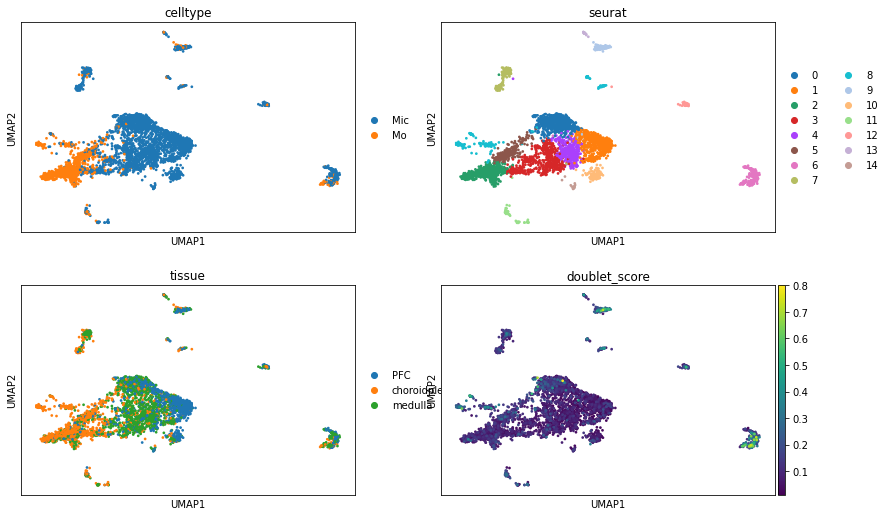

In [6]:
#sc.pl.umap(data_obj, color = ['celltype', 'seurat', 'doublet_score'])
sc.pl.umap(data_obj, color = ['celltype', 'seurat', 'tissue', 'doublet_score'], ncols=2)

In [7]:
keep = set([0, 1, 2, 3, 4, 5, 7, 10, 14])

data_obj_sub = data_obj[[l in keep for l in data_obj.obs.seurat] ].copy()

cl2type = {}
for i, l in enumerate([0, 1, 3, 4, 7, 10, 14]):
    cl2type[l] = f'Mic-{i}'
    
for i, l in enumerate([2, 5]):
    cl2type[l] = f'Mo-{i}'

id2type = sorted(cl2type.values())

data_obj_sub.obs.seurat = [cl2type[s] for s in data_obj_sub.obs.seurat ]

/hpc/users/leeh36/miniconda3/envs/sc_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
data_obj_sub

AnnData object with n_obs × n_vars = 3377 × 10000
    obs: 'subject_id', 'tissue', 'tissue_id', 'pid', 'cluster', 'celltype', 'clinical', 'is_covid', 'doublet_score', 'seurat'
    uns: 'celltype_colors', 'seurat_colors', 'tissue_colors'
    obsm: 'X_umap'

... storing 'seurat' as categorical


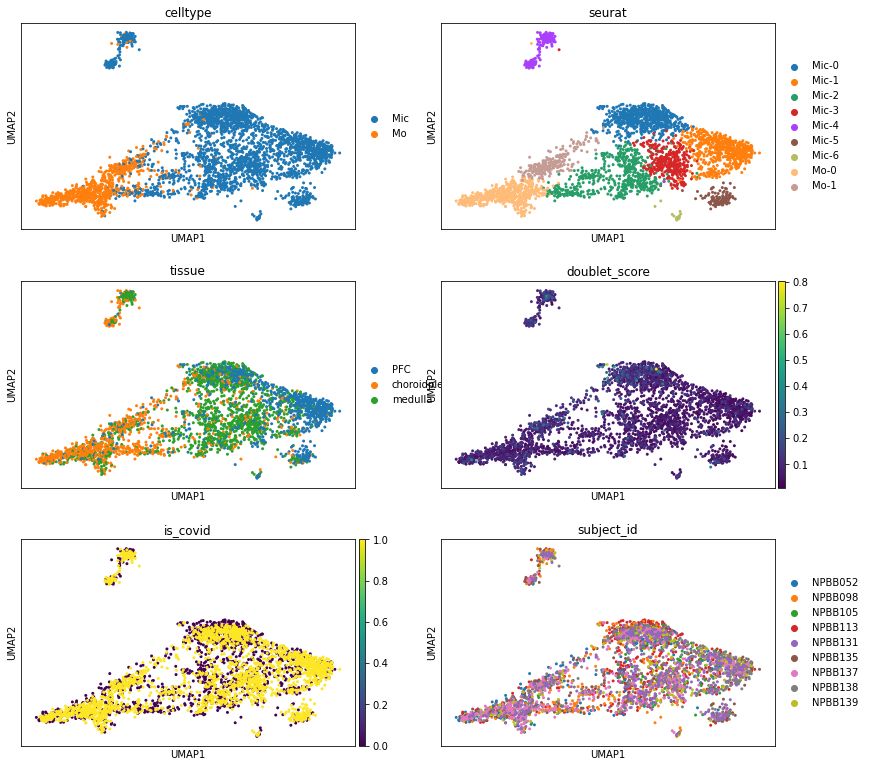

In [9]:
sc.pl.umap(data_obj_sub, color = ['celltype', 'seurat', 'tissue', 'doublet_score', 'is_covid', 'subject_id'], ncols=2)

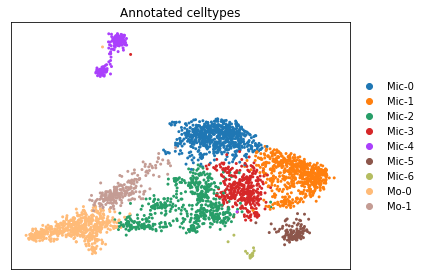

In [10]:
fig, axes = plt.subplots(1, 1, figsize = (6, 4))

ax = axes
sc.pl.umap(data_obj_sub, color = ['seurat'], show = False, ax = ax)
plt.sca(ax)
plt.xlabel('')
plt.ylabel('')
plt.title('Annotated celltypes')
plt.tight_layout()
plt.savefig('../../figs/umap_mic_mo.pdf')
plt.savefig("../../figs/png/umap_mic_mo.png", dpi = 600)
plt.show()

In [11]:
data_obj_sub.obs.is_covid = ['COVID' if s == 1 else 'ctrl' for s in data_obj_sub.obs.is_covid]
subject_id2showname = {'NPBB052':'Ctrl 1',
 'NPBB098':'Ctrl 2',
 'NPBB105':'Ctrl 3',
 'NPBB113':'Ctrl 4',
 'NPBB131':'Case 1',
 'NPBB135':'Case 2',
 'NPBB137':'Case 3',
 'NPBB138':'Case 4',
 'NPBB139':'Case 5',}
data_obj_sub.obs['showname'] = [subject_id2showname[s] for s in data_obj_sub.obs.subject_id]

... storing 'is_covid' as categorical
... storing 'showname' as categorical


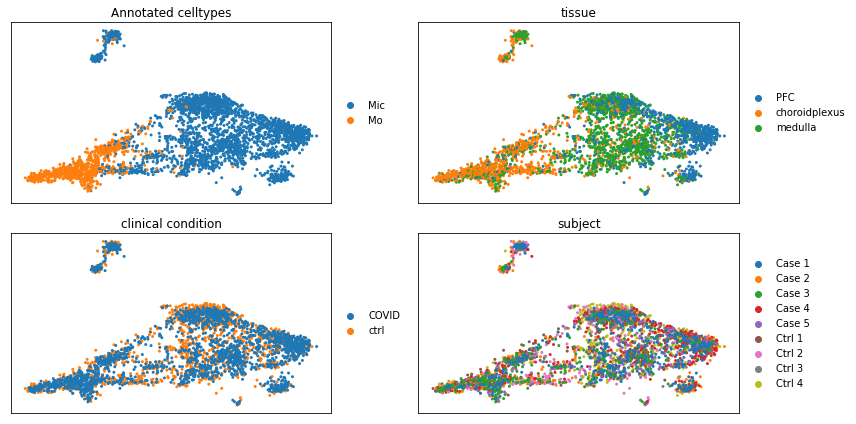

In [12]:
fig, axes = plt.subplots(2, 2, figsize = (12, 6))
ax = axes[0, 0]
sc.pl.umap(data_obj_sub, color = 'celltype', ax = ax, show = False)
plt.sca(ax)
plt.xlabel('')
plt.ylabel('')
plt.title('Annotated celltypes')
ax = axes[0, 1]
sc.pl.umap(data_obj_sub, color = 'tissue', ax = ax, show=False)
plt.sca(ax)
plt.xlabel('')
plt.ylabel('')
#plt.title('Annotated celltypes')
ax = axes[1, 0]
sc.pl.umap(data_obj_sub, color = 'is_covid', ax = ax, show=False)
plt.sca(ax)
plt.xlabel('')
plt.ylabel('')
plt.title('clinical condition')

ax = axes[1, 1]
sc.pl.umap(data_obj_sub, color = 'showname', ax = ax, show=False)
plt.sca(ax)
plt.xlabel('')
plt.ylabel('')
plt.title('subject')
plt.tight_layout()

plt.savefig('../../figs/umap_mic_mo_supp.pdf')
plt.savefig("../../figs/png/umap_mic_mo_supp.png", dpi = 600)
plt.show()

In [13]:
df_marker = pd.read_csv('./seurat_markers.csv')
#df_marker = df_marker[[l in keep for l in df_marker.cluster]]
df_marker.cluster = [cl2type[l] for l in df_marker.cluster]
#df_marker = df_marker[df_marker.cluster < 4]

In [14]:
genes = list(set(pd.concat([item.sort_values('p_val_adj').iloc[:5, ] for k, item in df_marker.groupby('cluster')]).gene))

In [15]:
df_sub = df_marker[[g in genes for g in df_marker.gene]]
df_sub = df_sub.sort_values('cluster')

In [16]:
df_sub

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
HIF1A,1.228004e-81,-0.964065,0.253,0.770,1.228004e-77,Mic-0,HIF1A
P2RY12,1.299152e-03,0.351054,0.250,0.375,1.000000e+00,Mic-0,P2RY12
NAV3,8.312935e-08,0.362922,0.576,0.525,8.312935e-04,Mic-0,NAV3
SYNDIG1,2.095111e-11,0.483113,0.576,0.513,2.095111e-07,Mic-0,SYNDIG1
MRC1,5.830316e-45,-1.533741,0.042,0.312,5.830316e-41,Mic-0,MRC1
...,...,...,...,...,...,...,...
KCNIP1.4,5.084747e-22,-1.512849,0.022,0.337,5.084747e-18,Mo-1,KCNIP1
VAV3.1,4.476840e-20,1.249473,0.411,0.188,4.476840e-16,Mo-1,VAV3
MRC1.2,1.390548e-14,1.106583,0.433,0.244,1.390548e-10,Mo-1,MRC1
RNF149.4,6.112856e-05,0.545585,0.615,0.672,6.112856e-01,Mo-1,RNF149


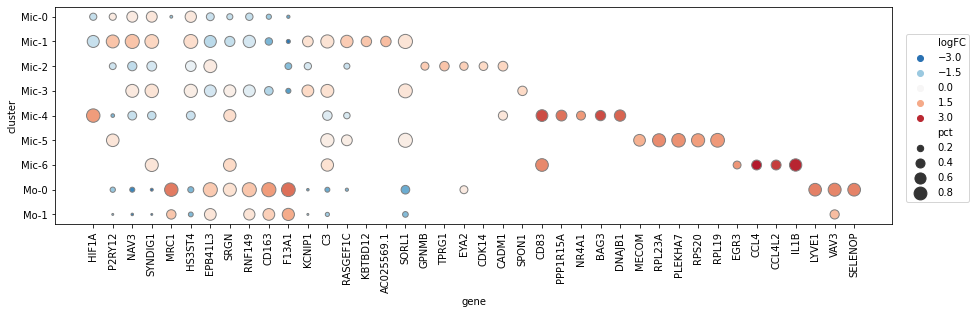

In [18]:
import seaborn as sns

df_plot = df_sub[['avg_logFC', 'pct.1', 'cluster', 'gene']].copy()
df_plot.columns = ['logFC', 'pct', 'cluster', 'gene']

fig = plt.figure(figsize = (15, 4))
sns.scatterplot(data = df_plot, x = 'gene', y = 'cluster',
                size = 'pct', hue = 'logFC', palette='RdBu_r',
                sizes=(0,200), hue_norm=(-4, 4), linewidth=1, edgecolor='gray')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.01, 0.9))

plt.savefig('../../figs/marker_mic_mo.pdf', bbox_inches='tight')
plt.savefig("../../figs/png/marker_mic_mo.png", dpi = 600, bbox_inches='tight')
plt.show()


In [198]:
df_marker[df_marker.gene == 'CD68']

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
CD68,1.785018e-10,0.482652,0.325,0.123,0.000002,Mic-5,CD68


In [36]:
data_obj_sub.obs['sample_id'] =  [f'{i}-{t}' for i, t in zip(data_obj_sub.obs.pid, data_obj_sub.obs.tissue_id)]

In [19]:
def get_freq_mat(df_count):
    ## input: df_count, assumed indexed by [(pid, ct)]
    num_ct = len(set([i[-1] for i in df_count.index]))
    
    index_mat = df_count.index.values.reshape(-1, num_ct)
    #print(index_mat)
    #for i in range(num_ct):
    #    assert len(set([s[1] for s in index_mat[:, i]])) == 1

    for i in range(index_mat.shape[0]):
        assert len(set([s[0] for s in index_mat[i, :]])) == 1

    count_mat = df_count.values.reshape((-1, num_ct))
    row_notallzero = (count_mat.sum(axis = 1) > 0)
    count_mat = count_mat[row_notallzero]
    index_mat = index_mat[row_notallzero]
    
    freq_mat = count_mat / count_mat.sum(axis = 1, keepdims = True)
    logfreq_mat = np.log10(freq_mat + 1e-5)      
    return count_mat, freq_mat, logfreq_mat, index_mat

sample_info = pd.read_csv('../../../round6/info/HTO_barcode_info.csv')
subject2clinical = {s:c for s, c in zip(sample_info.subject_id, sample_info.clinical)}

tid2tissue = {1: 'PFC',
 2: 'PFC',
 3: 'medulla',
 4: 'medulla',
 5: 'choroidplexus',
 6: 'choroidplexus'}

df_meta = data_obj_sub.obs.copy()
id2pid = sorted(set(df_meta.pid))
pid2subject = {p:s for s, p in zip(df_meta.subject_id, df_meta.pid)}
id2clinical = np.array([subject2clinical[pid2subject[p]] for p in id2pid])

df_count = df_meta
df_count = df_count.groupby(['pid', 'tissue_id', 'seurat']).count().iloc[:, 0]
df_count = df_count.fillna(0)

count_mat, freq_mat, logfreq_mat, index_mat = get_freq_mat(df_count)

id2ct = np.array([i[-1] for i in index_mat[0, :]])
id2pid = np.array([i[0] for i in index_mat[:, 0]])
id2subject = np.array([pid2subject[p] for p in id2pid])
id2clinical = np.array([subject2clinical[pid2subject[i[0]]] for i in index_mat[:, 0]])
id2tissue_id = np.array([int(i[1]) for i in index_mat[:, 0]])
id2tissue = np.array([tid2tissue[int(i[1])] for i in index_mat[:, 0]])

In [20]:
df_plot = pd.DataFrame({'freq': freq_mat.ravel(), 
            'celltype': [i[-1] for i in index_mat.ravel()],
             'clinical': [subject2clinical[pid2subject[i[0]]].split('_')[0] for i in index_mat.ravel()],
             'tissue': [tid2tissue[int(i[1])] for i in index_mat.ravel()]
             })

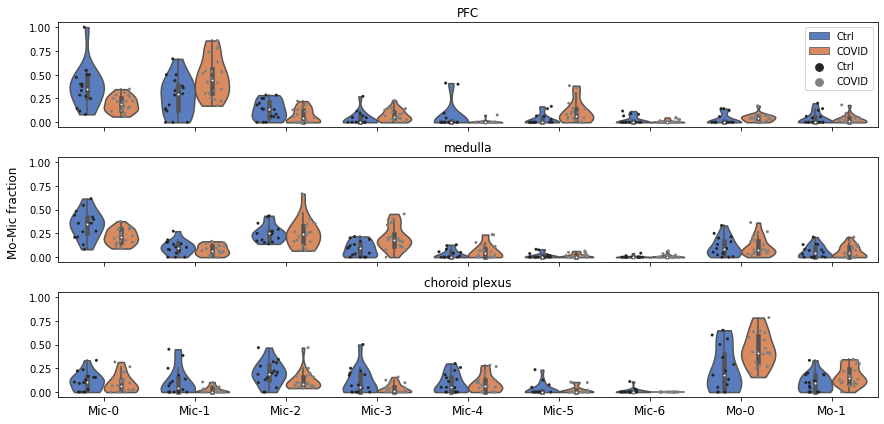

In [21]:
import seaborn as sns

fig, axes = plt.subplots(3, 1, figsize = (12, 6), sharex=True, sharey=True)

for ip, t in enumerate(['PFC', 'medulla', 'choroidplexus']):
    tmp = df_plot[df_plot.tissue == t]
    ax = sns.stripplot(x="celltype", y="freq", size = 3, hue = 'clinical',
                    data=tmp, ax = axes[ip], color = 'gray', jitter=0.25, dodge=True)
    
    ax = sns.violinplot(x="celltype", y="freq", hue="clinical", scale = 'width',
                    data=tmp, palette="muted", ax = axes[ip], cut = 0, width = .75)
    plt.sca(ax)
    if t != 'choroidplexus':
        plt.title(t, fontsize = 12)
    else:
        plt.title('choroid plexus', fontsize = 12)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize = 12)
    
    if ip != 0:
        ax.get_legend().remove()
    else:
        plt.legend()
    
fig.text(-0.02, 0.5, 'Mo-Mic fraction', va='center', 
         rotation='vertical', fontsize = 12)
plt.tight_layout()

plt.savefig('../../figs/freq_mic_mo.pdf')
plt.savefig("../../figs/png/freq_mic_mo.png", dpi = 600)
plt.show()

In [175]:
def save_freq(fn, freq_mat, id2ct, id2pid, id2subject, id2tid, id2tissue, id2clinical):
    id2ct2 = [c.replace(':', '_').replace('?', '').replace('/', '') for c in id2ct]
    df = pd.DataFrame(freq_mat, columns = id2ct2)
    df['pid'] = id2pid
    df['subject'] = id2subject
    df['tissue_id'] = id2tid
    df['tissue'] = id2tissue
    df['clinical'] = id2clinical
    df['covid'] = (id2clinical != 'Ctrl').astype('int')
    df.to_csv(fn, index = False)
    
save_freq('freq_celltype.csv', freq_mat, id2ct, id2pid, id2subject, id2tissue_id, id2tissue, id2clinical)
save_freq('count_celltype.csv', count_mat, id2ct, id2pid, id2subject, id2tissue_id, id2tissue, id2clinical)